# Physics 512 - Optics Lab

## Tucker Knaak - Department of Physics, Creighton University - Spring 2022

### Fourier Optics Final Project

#### In an optical system, we can interpret this as the Fourier transform taking some transmission function of an electric field in the aperture plane and converting it into a spectrum of spatial frequencies in the spectrum plane, and vice-versa for the inverse Fourier transform.  Therefore, we can find the diffraction pattern formed from an aperture and use a Fourier transform to model and recreate the image. There are many uses of Fourier transforms, one of which is the process of spatial filtering.  By blocking certain ranges of spatial frequencies in the diffraction pattern of an aperture, we can manipulate the image.  Low-pass spatial filtering is used to improve the quality of a beam, and high-pass spatial filtering can be used to sharpen photographs.  In this report, we will investigate optical systems of three different apertures and record their diffraction patterns after one and two lenses

In [1]:
'''Required Libraries'''
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

'''Required Functions'''
from numpy.fft import fft2, ifft2
from numpy import exp, pi, sqrt

#### This class is used to investigate Fourier Optics.  The user can choose a hexagon, square, or circle aperture to calculate the diffraction patterns and irradiance on a screen for the theory and compare these to those of the measured data.  Low-pass and high-pass spatial filters can then be used to alter the diffraction patterns and irradiances.

In [2]:
class FourierOptics():
    
    '''Internal function to initialize the system'''
    def __init__(self, aperture_name: str):
        
        '''Given constants'''
        self.wavelength = 0.6328           #wavelength of HeNe laser [um]
        self.k = 2 * pi / self.wavelength  #wavenumber of HeNe laser [um^-1]
        self.num_points = 2**12            #number of points for Fourier transforms
        self.length = 10000                #total extent of image [um]
        
        '''Model'''
        self.color = ''
        self.aperture_name = aperture_name.lower()                    #shape of aperture      
        self.aperture_mask = None                                     #boolean mask to apply for aperture
        self.aperture = np.zeros([self.num_points, self.num_points])  #aperture drawing
        
        '''x-y boundaries for the images'''
        self.xvals = np.linspace(-0.5 * self.length, 0.5 * self.length, self.num_points)
        self.yvals = np.linspace(-0.5 * self.length, 0.5 * self.length, self.num_points)
        self.xi, self.yi = np.meshgrid(range(self.num_points), range(self.num_points))
        self.extent = [-0.5 * self.length, 0.5 * self.length, -0.5 * self.length, 0.5 * self.length]
        
        '''Frequency-domain variables; p = hbar * k'''
        self.shortest_spatial_period = 2 * self.length / self.num_points
        self.highest_spacial_frequency = 2 * pi / self.shortest_spatial_period
        
        '''Transverse frequencies'''
        self.xfreq = np.linspace(-self.highest_spacial_frequency, self.highest_spacial_frequency, self.num_points)
        self.yfreq = np.linspace(-self.highest_spacial_frequency, self.highest_spacial_frequency, self.num_points)
        self.xfreq = np.fft.ifftshift(self.xfreq)
        self.yfreq = np.fft.ifftshift(self.yfreq)
        self.kx, self.ky = np.meshgrid(self.xfreq, self.yfreq, indexing = 'ij')
        
        '''Forward frequency'''
        self.kz = np.zeros([self.num_points, self.num_points], dtype = float)
        self.kmask = self.kx**2 + self.ky**2 < 2  #boolean mask
        self.kz[self.kmask] = sqrt(self.k**2 - (self.kx[self.kmask]**2 + self.ky[self.kmask]**2))
        
        '''Spatial filters'''
        self.lowpass_mask = None   #boolean mask to apply for low-pass spatial filter
        self.highpass_mask = None  #boolean mask to apply for high-pass spatial filter
        self.lowpass = np.ones([self.num_points, self.num_points])   #low-pass spatial filter drawing
        self.highpass = np.ones([self.num_points, self.num_points])  #high-pass spatial filter drawing
        
        '''Calculated irradiances'''
        self.screen1 = []          #irradiance on screen after one Fourier transform
        self.screen2 = []          #irradiance on screen after two Fourier transforms
        self.screen_lowpass = []   #irradiance on screen after two Fourier transforms and low-pass filter
        self.screen_highpass = []  #irradiance on screen after two Fourier transforms and high-pass filter
        
        
    '''Internal function to create the given aperture mask and drawing'''
    def create_aperture(self):
        
        '''Boolean masks for given aperture'''
        if self.aperture_name == 'hexagon':
            self.aperture_mask = (abs(self.yvals[self.yi]) + 2.25*abs(self.xvals[self.xi])
                                  < 1370) & (abs(self.xvals[self.xi]) > 350)
            self.aperture_mask = self.aperture_mask | (abs(self.yvals[self.yi]) < 575) & (abs(self.xvals[self.xi]) < 350)
            self.aperture[self.aperture_mask] = 1
            
        elif self.aperture_name == 'square':
            self.aperture_mask = (abs(self.yvals[self.yi]) < 600) & (abs(self.xvals[self.xi]) < 600)
            self.aperture[self.aperture_mask] = 1
            
        elif self.aperture_name == 'circle':
            radius = 200
            self.aperture_mask = (self.yvals[self.yi]**2 + self.xvals[self.xi]**2 < radius**2)
            self.aperture[self.aperture_mask] = 1
            
            
    '''Function called by the user to plot the given aperture'''
    def plot_aperture(self):
        
        '''Create given aperture'''
        self.create_aperture()
        
        '''Create figure and plot aperture'''
        fig, ax = plt.subplots(1, 1, figsize = (8, 6))
        fig.tight_layout(pad = 3)
        ax.set_xlabel('Distance [um]')
        ax.set_ylabel('Distance [um]')
        ax.set_title(f'{self.aperture_name.title()} Aperture')
        ax.set_xlim([-750, 750])
        ax.set_ylim([-750, 750])
        im = ax.imshow(self.aperture, extent = self.extent, cmap = 'gist_gray')
        fig.colorbar(im, ax = ax)
        
        '''Save figure'''
        fig.savefig(f'c:/Users/Tucker Knaak/Downloads/{self.aperture_name.title()}Aperture.png')
        
        
    '''Internal function to create the low-pass / high-pass spatial filter masks and drawings'''
    def create_spatial_filters(self):
        
        '''Create low-pass spatial filter'''
        self.lowpass_mask = (abs(self.xvals[self.xi]) < 30000) & (abs(self.yvals[self.yi]) < 22000)
        self.lowpass_mask = self.lowpass_mask & (abs(self.xvals[self.xi]) > 3000) | (abs(self.yvals[self.yi]) > 2000)
        self.lowpass[self.lowpass_mask] = 0
        
        '''Create high-pass spatial filter'''
        self.highpass_mask = (abs(self.yvals[self.yi]**2 + abs(self.xvals[self.xi])**2 < 1500**2))
        self.highpass[self.highpass_mask] = 0
        
        
    '''Function called by the user to plot the low-pass / high-pass spatial filters'''
    def plot_spatial_filters(self):
        
        '''Create spatial filters'''
        self.create_spatial_filters()
        
        '''Create figure and plot spatial filters'''
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw = {'width_ratios': [1, 1]})
        fig.tight_layout(pad = 3)
        
        '''First figure --> Low-pass spatial filter'''
        ax1.set_xlabel('Distance [um]')
        ax1.set_ylabel('Distance [um]')
        ax1.set_title('Low-Pass Spatial Filter')
        ax1.set_xlim([-5000, 5000])
        ax1.set_ylim([-5000, 5000])
        im1 = ax1.imshow(self.lowpass, extent = self.extent, cmap = 'gist_gray')
        fig.colorbar(im1, ax = ax1)
        
        '''Second figure --> High-pass spatial filter'''
        ax2.set_xlabel('Distance [um]')
        ax2.set_ylabel('Distance [um]')
        ax2.set_title('High-Pass Spatial Filter')
        ax2.set_xlim([-5000, 5000])
        ax2.set_ylim([-5000, 5000])
        im2 = ax2.imshow(self.highpass, extent = self.extent, cmap = 'gist_gray')
        fig.colorbar(im2, ax = ax2)
        
        '''Save figure'''
        fig.savefig('c:/Users/Tucker Knaak/Downloads/SpatialFilters.png')
        
        
    '''Internal function to read a .csv of the measured data for the given aperture'''
    def read_csv(self):
        
        '''Read .csv files'''
        if self.aperture_name == 'hexagon':
            irradiance2 = pd.read_csv(f'{self.aperture_name.lower()}2.csv', header = None)
            irradianceLow = pd.read_csv(f'{self.aperture_name.lower()}Low.csv', header = None)
            irradianceHigh = pd.read_csv(f'{self.aperture_name.lower()}High.csv', header = None)
        else:
            irradiance1 = pd.read_csv(f'{self.aperture_name.lower()}1.csv', header = None)
            irradiance2 = pd.read_csv(f'{self.aperture_name.lower()}2.csv', header = None)
            irradianceLow = pd.read_csv(f'{self.aperture_name.lower()}Low.csv', header = None)
            irradianceHigh = pd.read_csv(f'{self.aperture_name.lower()}High.csv', header = None)
        
        '''Normalize distances and irradiances for given aperture'''
        if self.aperture_name == 'hexagon':
            self.dist2 = [-3375 + 4.4 * num for num in range(1600)]
            self.dist_lowpass = [-4210 + 4.4 * num for num in range(1600)]
            self.dist_highpass = [-4100 + 4.4 * num for num in range(1600)]
            self.irradiance2 = [(i2 / 1250) - 0.05 for i2 in irradiance2.iloc[475, :-1].to_list()]
            self.irradiance_lowpass = [(iLow / 2500) + 0.016 for iLow in irradianceLow.iloc[523, :-1].to_list()]
            self.irradiance_highpass = [(iHigh / 20000) - 0.0025 for iHigh in irradianceHigh.iloc[640, :-1].to_list()]
            self.color = 'dodgerblue'
            
        elif self.aperture_name == 'square':
            self.dist1 = [-3280 + 4.4 * num for num in range(1600)]
            self.dist2 = [-4450 + 4.4 * num for num in range(1600)]
            self.dist_lowpass = [-4075 + 4.4 * num for num in range(1600)]
            self.dist_highpass = [-4150 + 4.4 * num for num in range(1600)]
            self.irradiance1 = [(i1 / 4.5) - 12 for i1 in irradiance1.iloc[575, :-1].to_list()]
            self.irradiance2 = [(i2 / 1000) - 0.045 for i2 in irradiance2.iloc[475, :-1].to_list()]
            self.irradiance_lowpass = [(iLow / 2300) - 0.02 for iLow in irradianceLow.iloc[235, :-1].to_list()]
            self.irradiance_highpass = [(iHigh / 40000) - 0.001 for iHigh in irradianceHigh.iloc[516, :-1].to_list()]
            self.color = 'limegreen'
            
        elif self.aperture_name == 'circle':
            self.dist1 = [-3055 + 4.4 * num for num in range(1600)]
            self.dist2 = [-3675 + 4.4 * num for num in range(1600)]
            self.dist_lowpass = [-2965 + 4.4 * num for num in range(1600)]
            self.dist_highpass = [-2990 + 4.4 * num for num in range(1600)]
            self.irradiance1 = [(i1 / 425) for i1 in irradiance1.iloc[677, :-1].to_list()]
            self.irradiance2 = [(i2 / 3450) for i2 in irradiance2.iloc[476, :-1].to_list()]
            self.irradiance_lowpass = [(iLow / 2750) for iLow in irradianceLow.iloc[837, :-1].to_list()]
            self.irradiance_highpass = [(iHigh / 60000) for iHigh in irradianceHigh.iloc[535, :-1].to_list()]
            self.color = 'red'
            
            
    '''Internal function to calculate the electric field after a thin-lens of focal length f'''
    def lensEfield(self, eField: list, f: float):
        
        '''Return electric field'''
        return eField * exp(1j * self.k * (sqrt(self.xvals[self.xi]**2 + self.yvals[self.yi]**2 + f**2) - f))
    
    
    '''Internal function to propagate the electric field a distance z0 perpendicular to the electric field'''
    def propEfield(self, eField: list, z0: float):
        
        '''Take Fourier transform and propagate electric field'''
        resultFFT = fft2(eField)
        propagateFFT = np.zeros([self.num_points, self.num_points], dtype = complex)
        propagateFFT[self.kmask] = resultFFT[self.kmask] * exp(1j * z0 * self.k * (self.k / self.kz[self.kmask] - 1))
        
        '''Return electric field'''
        return ifft2(propagateFFT)
        
        
    '''Function called by the user to plot the one and two calculated Fourier transforms of the given aperture'''
    def plot_fourier_transforms(self):
        
        '''Create given aperture'''
        self.create_aperture()
        
        '''Set electric field'''
        eField = sqrt(self.aperture)  #note that electric field is complex
        
        '''One Fourier transform'''
        eField = self.propEfield(eField, 75000)  #propagate electric field 75mm
        eField = self.lensEfield(eField, 75000)  #apply lens of focal length 75mm
        eField = self.propEfield(eField, 75000)  #propagate electric field 75mm
        self.screen1 = abs(eField)**2            #irradiance at screen
        
        '''Two Fourier transforms'''
        eField = self.propEfield(eField, 75000)  #propagate electric field 75mm
        eField = self.lensEfield(eField, 75000)  #apply lens of focal length 75mm
        eField = self.propEfield(eField, 75000)  #propagate electric field 75mm
        self.screen2 = abs(eField)**2            #irradiance at screen
        
        '''Create figure and plot results'''
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw = {'width_ratios': [1, 1]})
        fig.tight_layout(pad = 3)
        
        '''First figure --> One Fourier transform'''
        ax1.set_xlabel('Distance [um]')
        ax1.set_ylabel('Distance [um]')
        ax1.set_title(f'One Fourier Transform - {self.aperture_name.title()} Aperture')
        ax1.set_xlim([-250, 250])
        ax1.set_ylim([-250, 250])
        im1 = ax1.imshow(self.screen1, extent = self.extent, cmap = 'gist_gray', vmin = 0, vmax = 1)
        fig.colorbar(im1, ax = ax1)
        
        '''Second figure --> Two Fourier transforms'''
        ax2.set_xlabel('Distance [um]')
        ax2.set_ylabel('Distance [um]')
        ax2.set_title(f'Two Fourier Transforms - {self.aperture_name.title()} Aperture')
        ax2.set_xlim([-750, 750])
        ax2.set_ylim([-750, 750])
        im2 = ax2.imshow(self.screen2, extent = self.extent, cmap = 'gist_gray', vmin = 0, vmax = 1)
        fig.colorbar(im2, ax = ax2)
        
        '''Save figure'''
        fig.savefig(f'c:/Users/Tucker Knaak/Downloads/FourierTransforms_{self.aperture_name.title()}.png')
        
        
    '''Function called by the user to plot the two calculated Fourier transforms of the given aperture
       for both a low-pass and high-pass spatial filter applied'''
    def plot_fourier_transforms_filters(self):
        
        '''Create given aperture'''
        self.create_aperture()
        
        '''Set electric fields'''
        eField1 = sqrt(self.aperture)  #note that electric field is complex
        eField2 = sqrt(self.aperture)  #note that electric field is complex
        
        '''One Fourier transform'''
        eField1 = self.propEfield(eField1, 75000)  #propagate electric field 75mm
        eField1 = self.lensEfield(eField1, 75000)  #apply lens of focal length 75mm
        eField1 = self.propEfield(eField1, 75000)  #propagate electric field 75mm
        eField2 = self.propEfield(eField2, 75000)  #propagate electric field 75mm
        eField2 = self.lensEfield(eField2, 75000)  #apply lens of focal length 75mm
        eField2 = self.propEfield(eField2, 75000)  #propagate electric field 75mm
        
        '''Apply low-pass / high-pass spatial filters'''
        self.create_spatial_filters()
        eField1[self.lowpass_mask] = 0
        eField2[self.highpass_mask] = 0
        
        '''Two Fourier transforms'''
        eField1 = self.propEfield(eField1, 75000)  #propagate electric field 75mm
        eField1 = self.lensEfield(eField1, 75000)  #apply lens of focal length 75mm
        eField1 = self.propEfield(eField1, 75000)  #propagate electric field 75mm
        eField2 = self.propEfield(eField2, 75000)  #propagate electric field 75mm
        eField2 = self.lensEfield(eField2, 75000)  #apply lens of focal length 75mm
        eField2 = self.propEfield(eField2, 75000)  #propagate electric field 75mm
        self.screen_lowpass = abs(eField1)**2      #irradiance at screen after low-pass filter
        self.screen_highpass = abs(eField2)**2     #irradiance at screen after high-pass filter
        
        '''Create figure and plot results'''
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw = {'width_ratios': [1, 1]})
        fig.tight_layout(pad = 3)
        
        '''First figure --> Low-pass spatial filter'''
        ax1.set_xlabel('Distance [um]')
        ax1.set_ylabel('Distance [um]')
        ax1.set_title(f'Two Fourier Transforms - Low-Pass Spatial Filter - {self.aperture_name.title()} Aperture')
        ax1.set_xlim([-750, 750])
        ax1.set_ylim([-750, 750])
        im1 = ax1.imshow(self.screen_lowpass, extent = self.extent, cmap = 'gist_gray', vmin = 0, vmax = 1)
        fig.colorbar(im1, ax = ax1)
        
        '''Second figure --> High-pass spatial filter'''
        ax2.set_xlabel('Distance [um]')
        ax2.set_ylabel('Distance [um]')
        ax2.set_title(f'Two Fourier Transforms - High-Pass Spatial Filter - {self.aperture_name.title()} Aperture')
        ax2.set_xlim([-750, 750])
        ax2.set_ylim([-750, 750])
        im2 = ax2.imshow(self.screen_highpass, extent = self.extent, cmap = 'gist_gray', vmin = 0, vmax = 0.1)
        fig.colorbar(im2, ax = ax2)
        
        '''Save figure'''
        fig.savefig(f'c:/Users/Tucker Knaak/Downloads/SpatialFilters_{self.aperture_name.title()}.png')
        
        
    '''Function called by the user to plot the irradiance on the first and second screen
       for the given aperture compared to that of the calculated irradiance'''
    def plot_irradiance(self):
        
        '''Populate measured irradiances'''
        self.read_csv()
        
        '''No data for one Fourier transform of hexagon aperture'''
        if self.aperture_name == 'hexagon':
            
            '''Create figure and plot results'''
            fig, ax = plt.subplots(1, 1, figsize = (8, 6))
            fig.tight_layout(pad = 3)
            ax.set_xlabel('Distance From Center of CCD Camera [um]')
            ax.set_ylabel('Normalized Irradiance [W / m$^2$]')
            ax.set_title(f'Irradiance - Two Fourier Transforms - {self.aperture_name.title()} Aperture')
            ax.set_xlim([-1500, 1500])
            ax.grid(True, linestyle = 'dashed', color = 'darkgray', alpha = 0.25)
            ax.plot(self.xvals, self.screen2[self.num_points // 2, :], linestyle = 'solid',
                    color = self.color, label = 'Calculated')
            ax.plot(self.yvals, self.screen2[:, self.num_points // 2], linestyle = 'solid', color = self.color)
            ax.plot(self.dist2, self.irradiance2, linestyle = 'solid', color = 'black', label = 'Measured')
            ax.legend(loc = 'upper right')
            
            '''Save figure'''
            fig.savefig(f'c:/Users/Tucker Knaak/Downloads/Irradiance_{self.aperture_name.title()}Aperture.png')
            
        else:
            
            '''Create figure and plot results'''
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw = {'width_ratios': [1, 1]})
            fig.tight_layout(pad = 5)
            
            '''First figure --> One Fourier transform'''
            ax1.set_xlabel('Distance From Center of CCD Camera [um]')
            ax1.set_ylabel('Normalized Irradiance [W / m$^2$]')
            ax1.set_title(f'Irradiance - One Fourier Transform - {self.aperture_name.title()} Aperture')
            ax1.set_xlim([-500, 500])
            ax1.grid(True, linestyle = 'dashed', color = 'darkgray', alpha = 0.25)
            ax1.plot(self.xvals, self.screen1[self.num_points // 2, :], linestyle = 'solid',
                     color = self.color, label = 'Calculated')
            ax1.plot(self.yvals, self.screen1[:, self.num_points // 2], linestyle = 'solid', color = self.color)
            ax1.plot(self.dist1, self.irradiance1, linestyle = 'solid', color = 'black', label = 'Measured')
            ax1.legend(loc = 'upper right')
            
            '''Second figure --> Two Fourier transforms'''
            ax2.set_xlabel('Distance From Center of CCD Camera [um]')
            ax2.set_ylabel('Normalized Irradiance [W / m$^2$]')
            ax2.set_title(f'Irradiance - Two Fourier Transforms - {self.aperture_name.title()} Aperture')
            ax2.set_xlim([-1500, 1500])
            ax2.grid(True, linestyle = 'dashed', color = 'darkgray', alpha = 0.25)
            ax2.plot(self.xvals, self.screen2[self.num_points // 2, :], linestyle = 'solid',
                     color = self.color, label = 'Calculated')
            ax2.plot(self.yvals, self.screen2[:, self.num_points // 2], linestyle = 'solid', color = self.color)
            ax2.plot(self.dist2, self.irradiance2, linestyle = 'solid', color = 'black', label = 'Measured')
            ax2.legend(loc = 'upper right')
            
            '''Save figure'''
            fig.savefig(f'c:/Users/Tucker Knaak/Downloads/Irradiance_{self.aperture_name.title()}Aperture.png')
            
            
    '''Function called by the user to plot the irradiance on the second screen after both a low-pass
       and high-pass spatial filter for the given aperture compared to that of the calculated irradiance'''
    def plot_irradiance_filters(self):
        
        '''Populate measured irradiances'''
        self.read_csv()
        
        '''Create figure and plot results'''
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), gridspec_kw = {'width_ratios': [1, 1]})
        fig.tight_layout(pad = 5)
        
        '''First figure --> Low-pass spatial filter'''
        ax1.set_xlabel('Distance From Center of CCD Camera [um]')
        ax1.set_ylabel('Normalized Irradiance [W / m$^2$]')
        ax1.set_title(f'Irradiance - Low-Pass Spatial Filter - {self.aperture_name.title()} Aperture')
        ax1.set_xlim([-1500, 1500])
        ax1.grid(True, linestyle = 'dashed', color = 'darkgray', alpha = 0.25)
        ax1.plot(self.xvals, self.screen_lowpass[self.num_points // 2, :], linestyle = 'solid',
                 color = self.color, label = 'Calculated')
        ax1.plot(self.yvals, self.screen_lowpass[:, self.num_points // 2], linestyle = 'solid', color = self.color)
        ax1.plot(self.dist_lowpass, self.irradiance_lowpass, linestyle = 'solid', color = 'black', label = 'Measured')
        ax1.legend(loc = 'upper right')
        
        '''Second figure --> High-pass spatial filter'''
        ax2.set_xlabel('Distance From Center of CCD Camera [um]')
        ax2.set_ylabel('Normalized Irradiance [W / m$^2$]')
        ax2.set_title(f'Irradiance - High-Pass Spatial Filter - {self.aperture_name.title()} Aperture')
        ax2.set_xlim([-1500, 1500])
        ax2.grid(True, linestyle = 'dashed', color = 'darkgray', alpha = 0.25)
        ax2.plot(self.xvals, self.screen_highpass[self.num_points // 2, :], linestyle = 'solid',
                 color = self.color, label = 'Calculated')
        ax2.plot(self.yvals, self.screen_highpass[:, self.num_points // 2], linestyle = 'solid', color = self.color)
        ax2.plot(self.dist_highpass, self.irradiance_highpass, linestyle = 'solid', color = 'black', label = 'Measured')
        ax2.legend(loc = 'upper right')
        
        '''Save figure'''
        fig.savefig(f'c:/Users/Tucker Knaak/Downloads/Irradiance_SpatialFilters_{self.aperture_name.title()}Aperture.png')

### Low-pass and High-pass spatial filters.

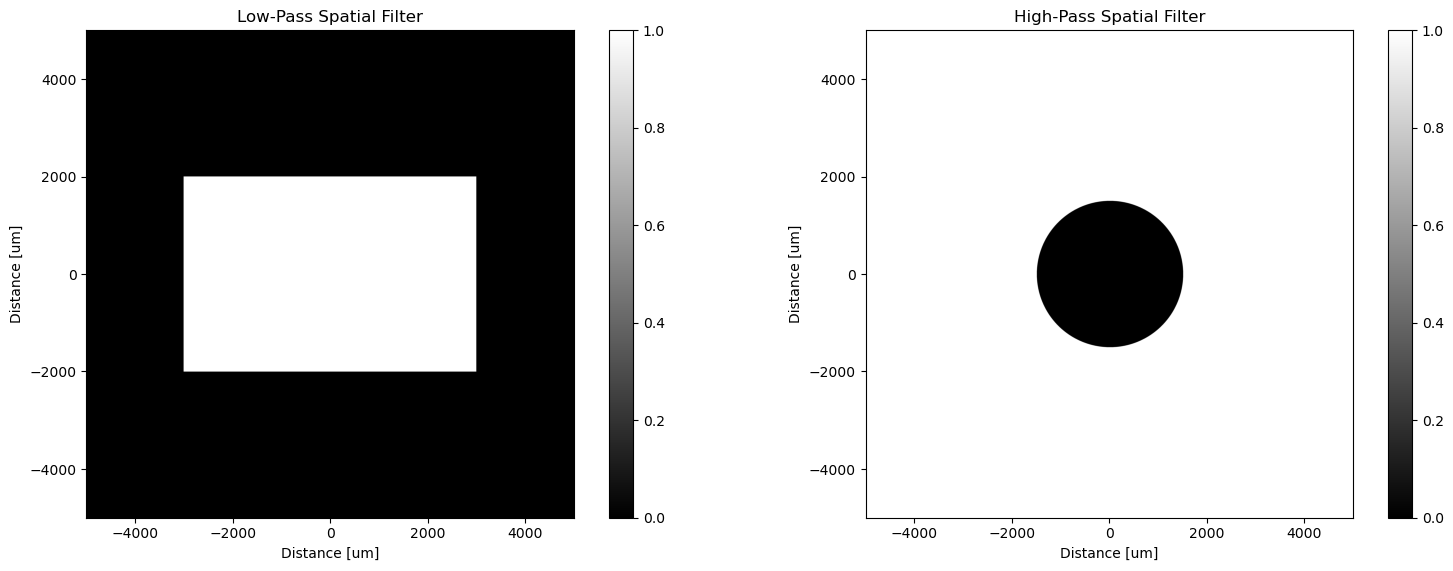

In [3]:
filters = FourierOptics('')
filters.plot_spatial_filters()

### Hexagon Aperture.

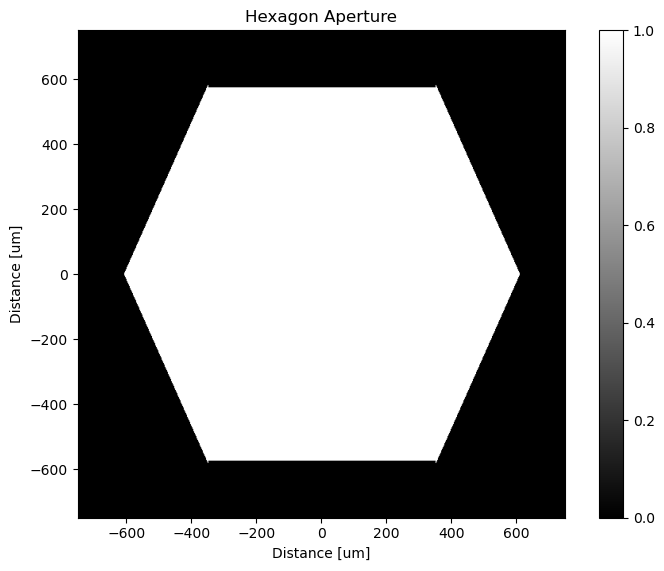

In [4]:
hexagon = FourierOptics('hexagon')
hexagon.plot_aperture()

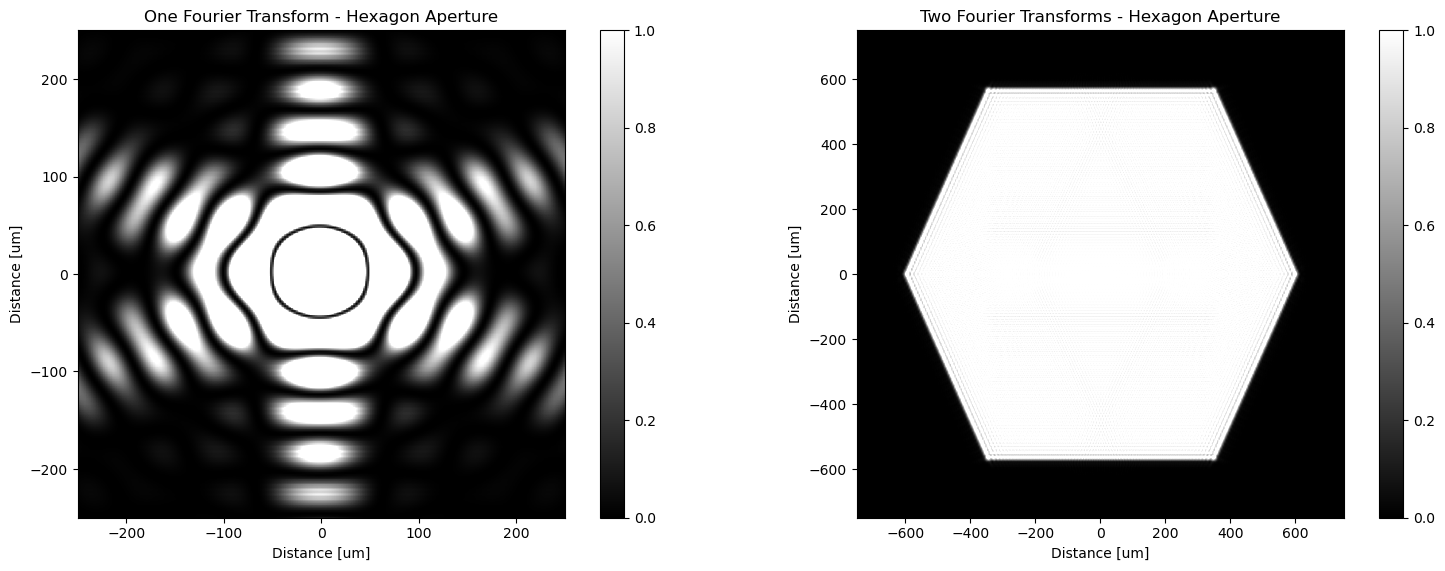

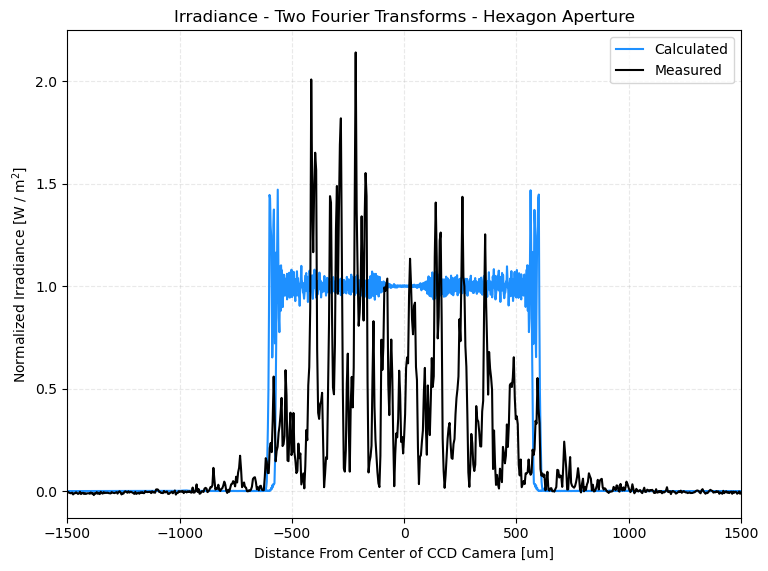

In [5]:
hexagon.plot_fourier_transforms()
hexagon.plot_irradiance()

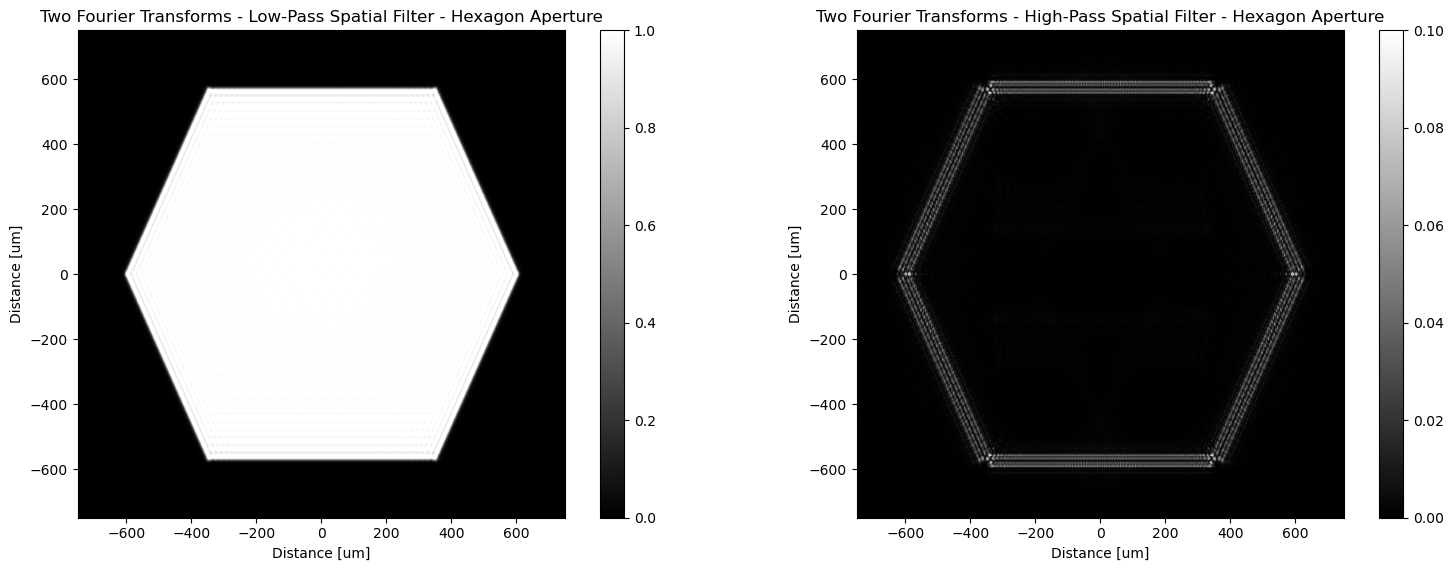

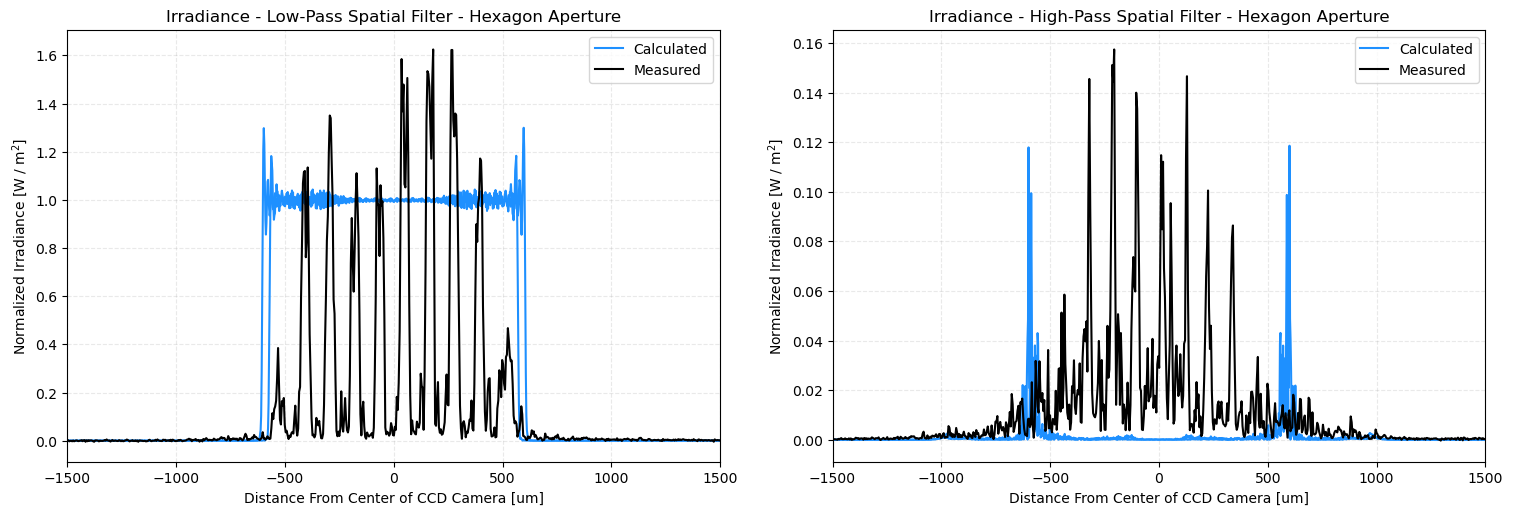

In [6]:
hexagon.plot_fourier_transforms_filters()
hexagon.plot_irradiance_filters()

### Square Aperture.

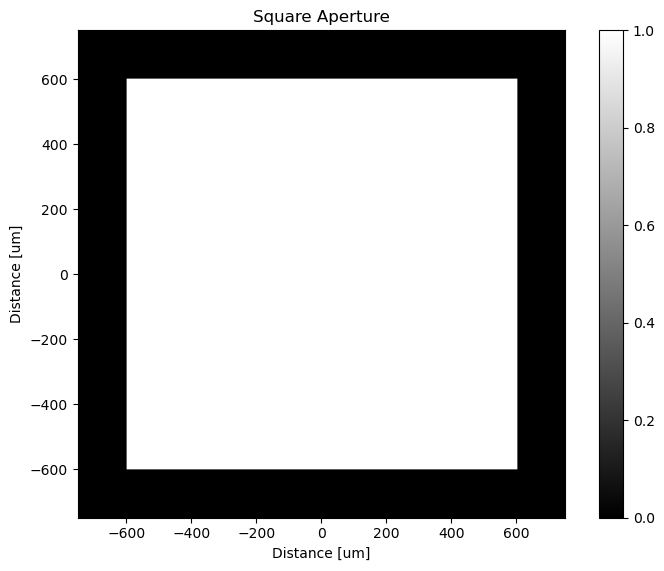

In [7]:
square = FourierOptics('square')
square.plot_aperture()

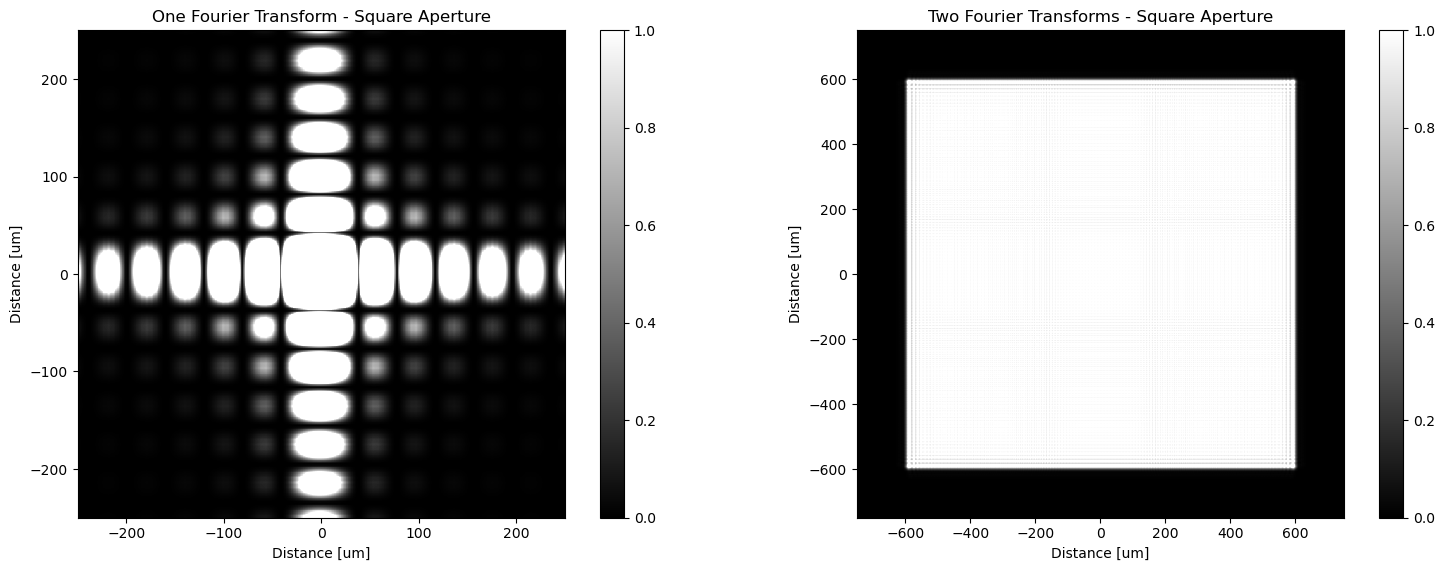

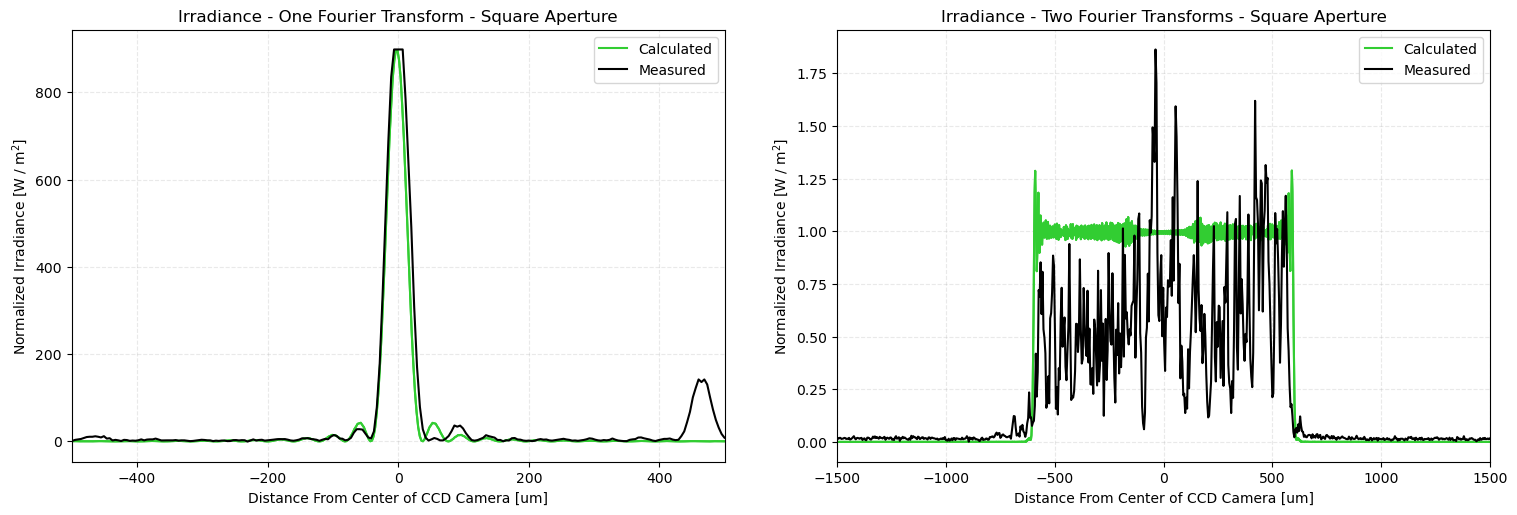

In [8]:
square.plot_fourier_transforms()
square.plot_irradiance()

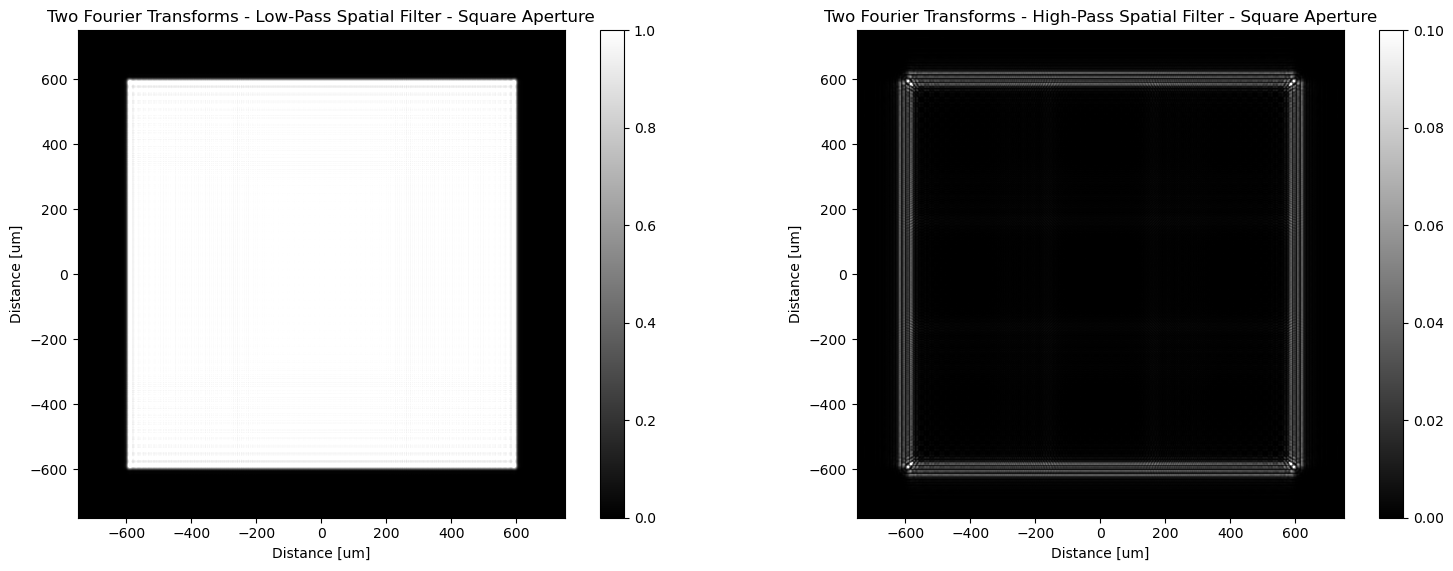

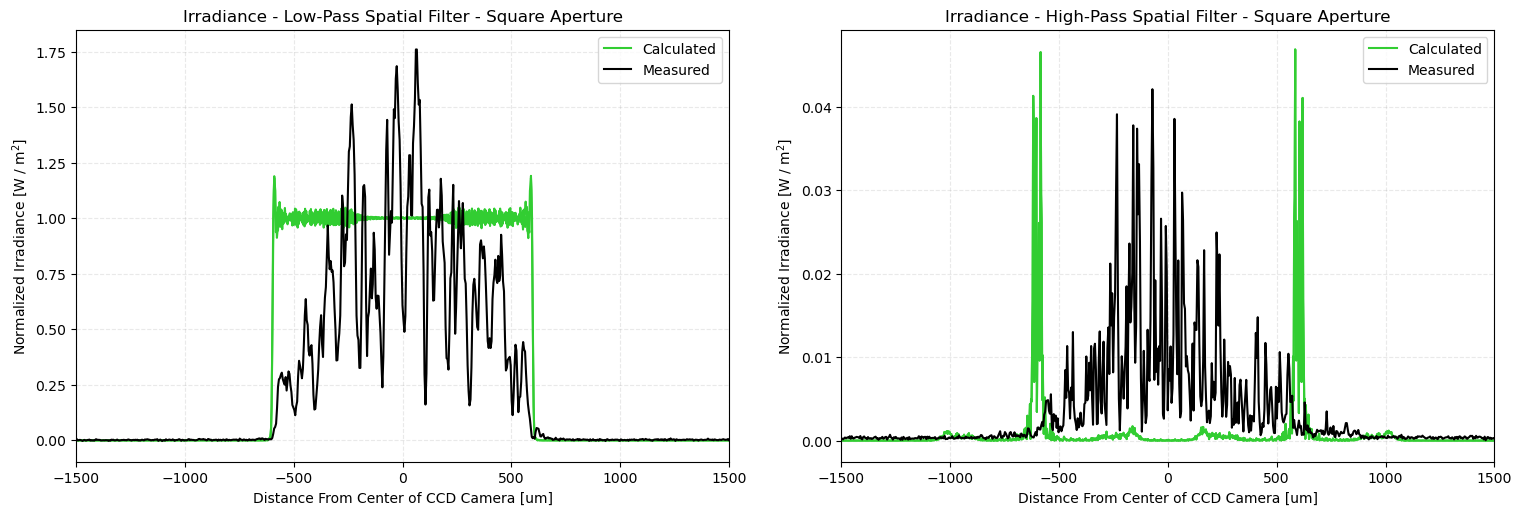

In [9]:
square.plot_fourier_transforms_filters()
square.plot_irradiance_filters()

### Circle Aperture.

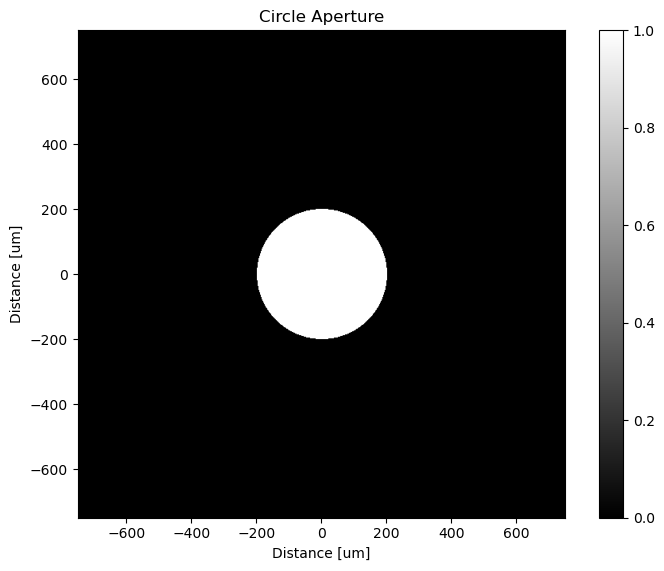

In [10]:
circle = FourierOptics('circle')
circle.plot_aperture()

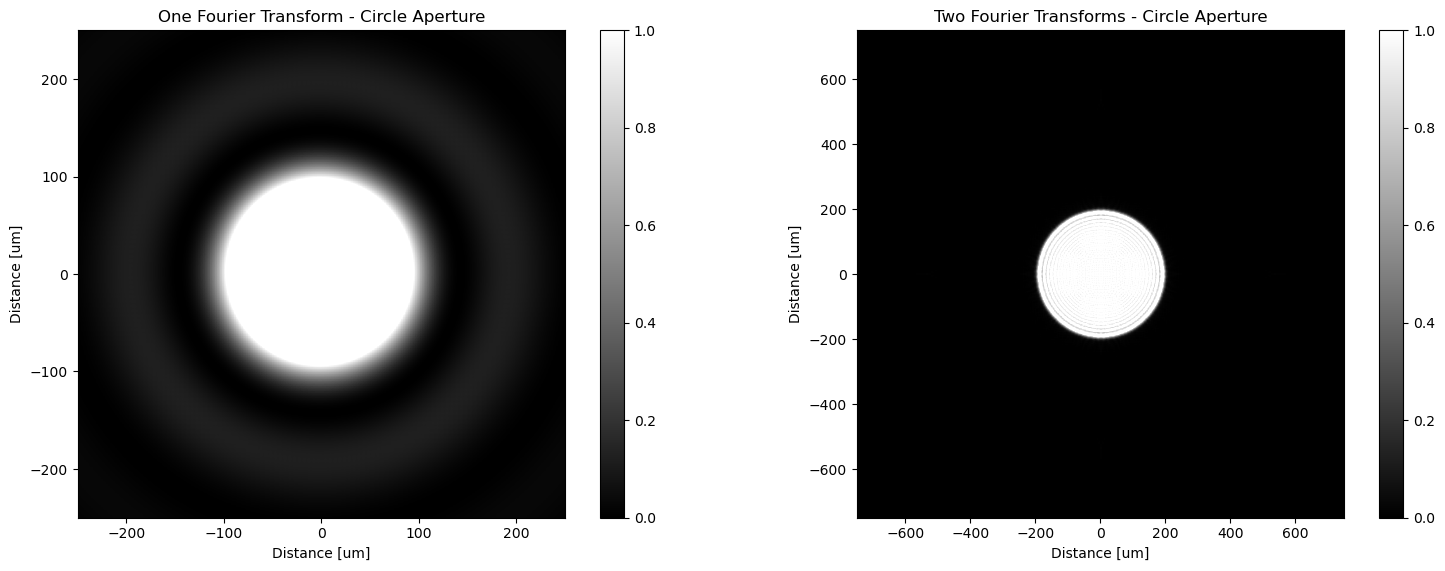

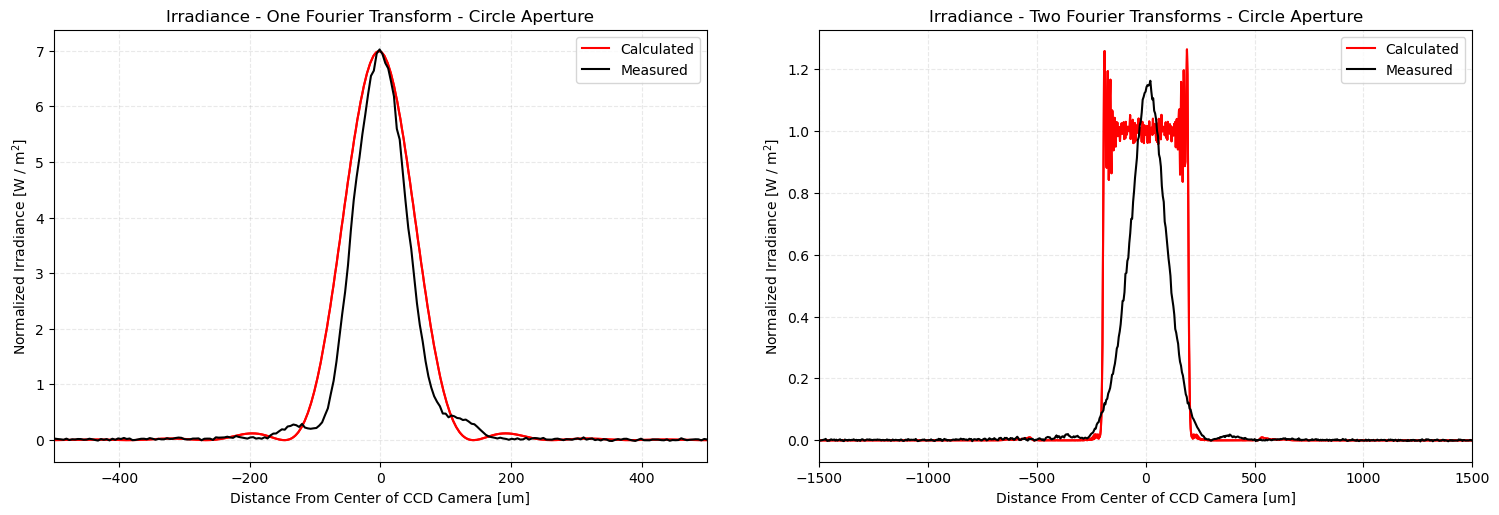

In [11]:
circle.plot_fourier_transforms()
circle.plot_irradiance()

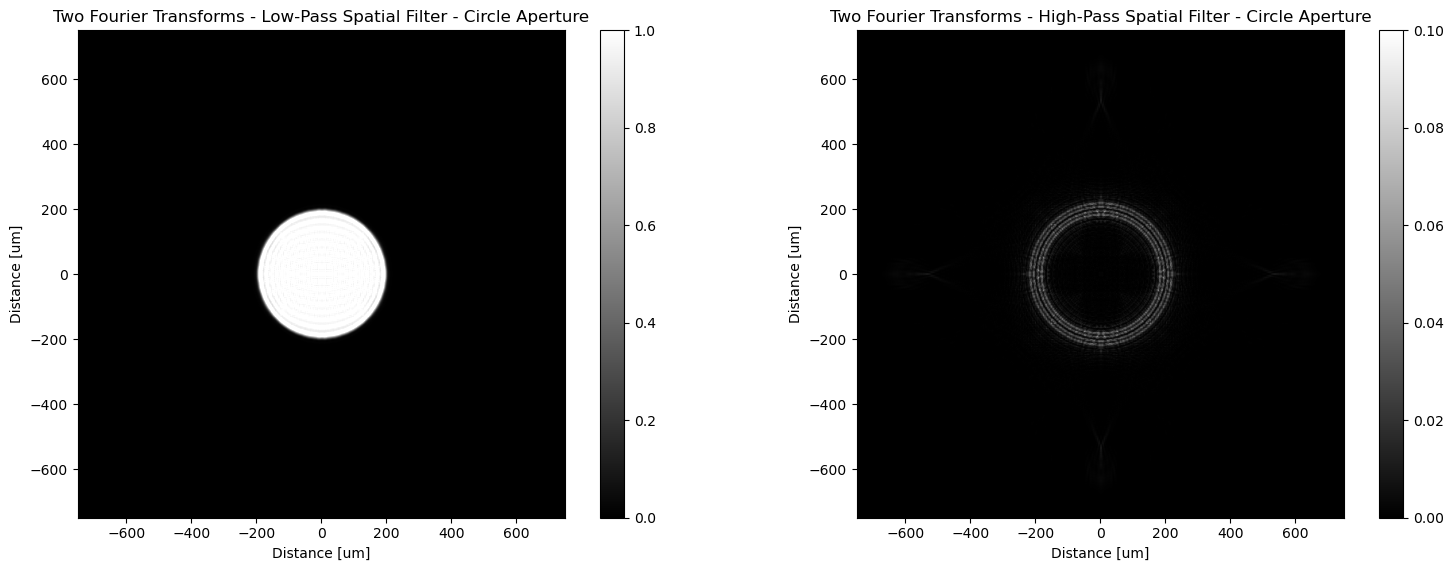

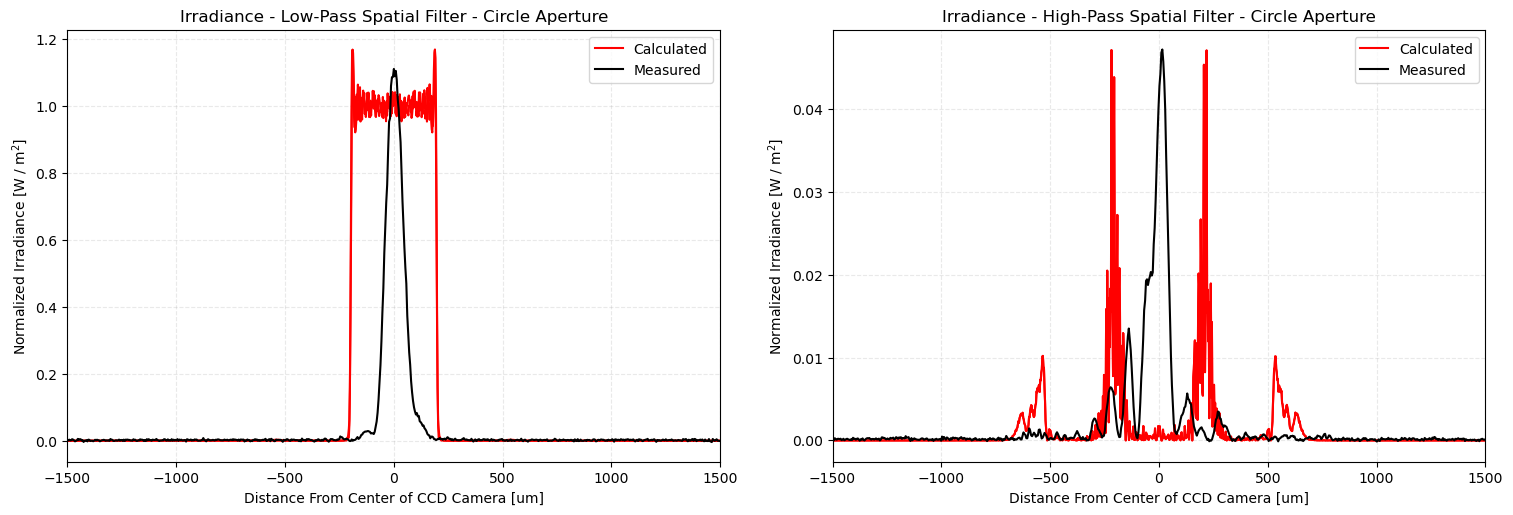

In [12]:
circle.plot_fourier_transforms_filters()
circle.plot_irradiance_filters()